In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [2]:
df = pd.read_csv('database/aggregated_info/preprocessed_content_analysis.csv', index_col=0)

In [3]:
# prepare data for cluatering
df['normalized_abstract'] = df['normalized_abstract'].apply(ast.literal_eval)
df['normalized_abstract'] = df['normalized_abstract'].apply(lambda x: ' '.join(x))

In [4]:
# group by email and concatenate abstracts
cluster_df = df.groupby('email')['normalized_abstract'].apply(lambda x: '. '.join(x)).reset_index()

In [5]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# generate TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_df['normalized_abstract'])

In [6]:
# fit SVD
n_components = min(tfidf_matrix.shape) - 1
svd = TruncatedSVD(n_components=n_components)
svd.fit(tfidf_matrix)

# calculate the cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)

# calculate the number of SVD components capturing 95% variance 
num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
num_components

526

In [7]:
# fit and transform TF-IDF matrix
svd = TruncatedSVD(n_components=526)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

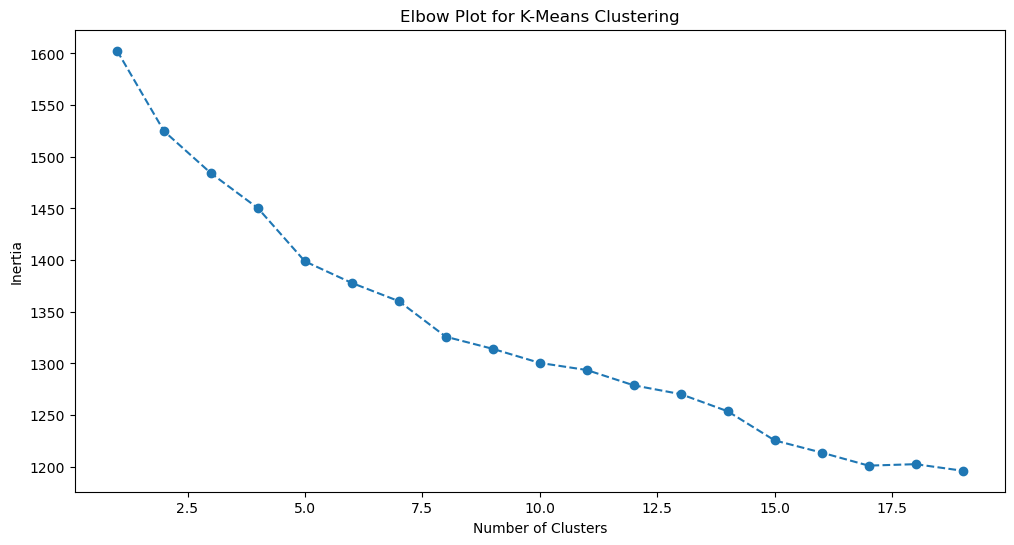

In [8]:
num_clusters = range(1, 20)

# calculate the inertia for each number of clusters
inertias = []
for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix_reduced)
    inertias.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(12, 6))
plt.plot(num_clusters, inertias, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot for K-Means Clustering')
plt.show()

In [9]:
# perform K-means clustering on TF-IDF matrix
kmeans_tfidf = KMeans(n_clusters=5, random_state=42)
kmeans_tfidf.fit(tfidf_matrix_reduced)

# add cluster labels to the dataframe
cluster_df['tfidf_cluster'] = kmeans_tfidf.labels_

In [10]:
# Word2Vec Vectorization
word2vec_model = Word2Vec(sentences=cluster_df['normalized_abstract'].sum(), vector_size=300, window=5, min_count=10, workers=6, sg=1)

def vectorize(abstract, model):
    vector = np.mean([model.wv[word] for word in abstract if word in model.wv] or [np.zeros(model.vector_size)], axis=0)
    return vector

# generate Word2Vec vectors
w2v_vectors = np.vstack(cluster_df['normalized_abstract'].apply(lambda x: vectorize(x, word2vec_model)))

In [11]:
# fit PCA
pca = PCA().fit(w2v_vectors)

# calculate the cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# calculate the number of PCA components capturing 95% variance 
num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
num_components

19

In [12]:
# fit and transform Word2Vec vectors
pca = PCA(n_components=19)
w2v_vectors_reduced = pca.fit_transform(w2v_vectors)

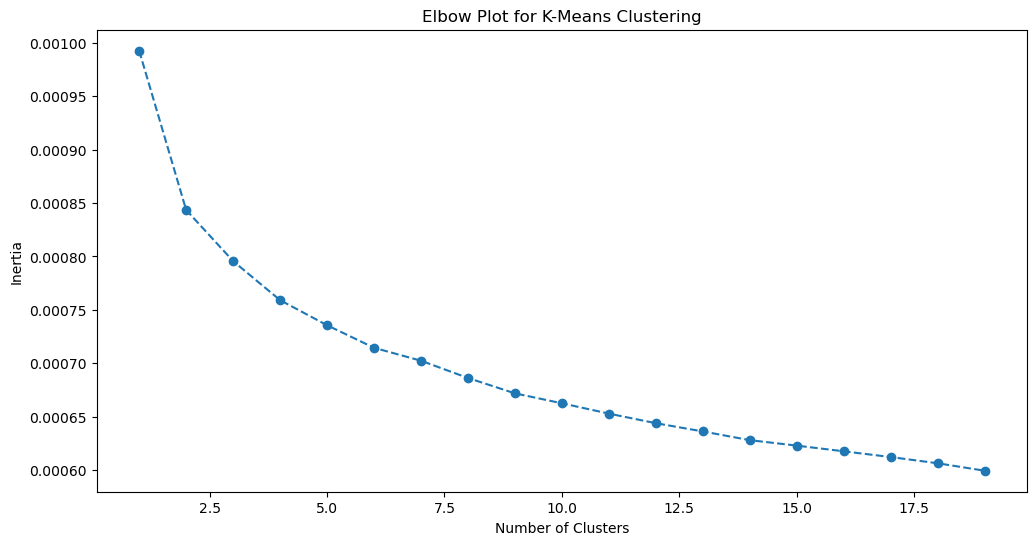

In [13]:
num_clusters = range(1, 20)

# calculate the inertia for each number of clusters
inertias = []
for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(w2v_vectors_reduced)
    inertias.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(12, 6))
plt.plot(num_clusters, inertias, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot for K-Means Clustering')
plt.show()

In [14]:
# perform K-means clustering on Word2Vec vectors
kmeans_w2v = KMeans(n_clusters=5, random_state=42)
kmeans_w2v.fit(w2v_vectors_reduced)

# add cluster labels to the dataframe
cluster_df['w2v_cluster'] = kmeans_w2v.labels_

In [15]:
# function to find the most distinctive words in each cluster
def find_distinctive_words_by_cluster(clusters):
    aggregate_tfidf_vectors_by_cluster = {}
    
    for i, cluster in enumerate(clusters):
        if cluster not in aggregate_tfidf_vectors_by_cluster:
            aggregate_tfidf_vectors_by_cluster[cluster] = tfidf_matrix[i]
        else:
            aggregate_tfidf_vectors_by_cluster[cluster] += tfidf_matrix[i]

    distinctive_words_by_cluster = {}
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    
    for cluster, agg_tfidf in aggregate_tfidf_vectors_by_cluster.items():
        sorted_indices = np.argsort(agg_tfidf.toarray()).flatten()[::-1]
        distinctive_words_by_cluster[cluster] = feature_names[sorted_indices][:20]

    for cluster, words in distinctive_words_by_cluster.items():
        print(f"Cluster {cluster}: {words}")

In [16]:
# find the most distinctive words in each TF-IDF cluster
find_distinctive_words_by_cluster(cluster_df['tfidf_cluster'])

Cluster 4: ['language' 'word' 'linguistic' 'speaker' 'speech' 'english' 'sentence'
 'child' 'verb' 'vowel' 'syntactic' 'study' 'semantic' 'listener' 'l2'
 'lexical' 'phonological' 'grammar' 'experiment' 'spanish']
Cluster 1: ['visual' 'memory' 'task' 'brain' 'neural' 'stimulus' 'study' 'object'
 'model' 'participant' 'cortex' 'cognitive' 'response' 'experiment'
 'control' 'human' 'information' 'learn' 'performance' 'network']
Cluster 3: ['child' 'study' 'social' 'health' 'woman' 'self' 'research' 'people'
 'behavior' 'emotion' 'participant' 'group' 'individual' 'experience'
 'examine' 'human' 'high' 'relationship' 'effect' 'infant']
Cluster 0: ['de' 'climate' 'social' 'change' 'archaeological' 'site' 'land' 'study'
 'water' 'political' 'datum' 'la' 'forest' 'research' 'new' 'community'
 'urban' 'environmental' 'model' 'region']
Cluster 2: ['primate' 'human' 'specie' 'fossil' 'bone' 'study' 'hominin' 'genetic'
 'population' 'site' 'gene' 'datum' 'archaeological' 'evolution' 'early'
 'an

In [17]:
# create a new mapping dictionary for each TF-IDF cluster
tfidf_cluster_mapping = {
    0: 'Environmental Studies',
    1: 'Cognitive Neuroscience',
    2: 'Anthropology',
    3: 'Social Psychology',
    4: 'Linguistics'
}

# apply the new mapping to the TF-IDF cluster labels
cluster_df['tfidf_cluster'] = cluster_df['tfidf_cluster'].map(tfidf_cluster_mapping)

In [18]:
# find the most distinctive words in each Word2Vec cluster
find_distinctive_words_by_cluster(cluster_df['w2v_cluster'])

Cluster 3: ['study' 'memory' 'participant' 'task' 'experiment' 'visual' 'effect'
 'self' 'social' 'research' 'stimulus' 'model' 'object' 'people' 'result'
 'emotion' 'information' 'test' 'cognitive' 'word']
Cluster 0: ['study' 'social' 'human' 'language' 'research' 'political' 'model'
 'change' 'new' 'datum' 'brain' 'community' 'system' 'cultural'
 'population' 'analysis' 'economic' 'network' 'state' 'result']
Cluster 2: ['study' 'model' 'social' 'datum' 'human' 'child' 'health' 'change'
 'research' 'result' 'high' 'system' 'climate' 'time' 'water' 'specie'
 'use' 'base' 'analysis' 'primate']
Cluster 1: ['language' 'child' 'word' 'english' 'linguistic' 'speaker' 'speech'
 'study' 'l2' 'bilingual' 'verb' 'research' 'sign' 'learn' 'spanish'
 'sentence' 'native' 'de' 'use' 'infant']
Cluster 4: ['de' 'archaeological' 'site' 'human' 'la' 'study' 'datum' 'fossil'
 'change' 'analysis' 'early' 'bone' 'region' 'en' 'climate' 'island'
 'date' 'el' 'social' 'land']


In [19]:
# # create a new mapping dictionary for each Word2Vec cluster
w2v_cluster_mapping = {
    0: 'Social Psychology',
    1: 'Languistics',
    2: 'Environmental Studies',
    3: 'Cognitive Neuroscience',
    4: 'Anthropology'
}

# apply the new mapping to the Word2Vec cluster labels
cluster_df['w2v_cluster'] = cluster_df['w2v_cluster'].map(w2v_cluster_mapping)

In [20]:
cluster_df.head(20)

,email,normalized_abstract,tfidf_cluster,w2v_cluster
0,00t0holtgrav@bsu.edu,interdisciplinary synthesis social psychologic...,Linguistics,Cognitive Neuroscience
1,a.satpute@northeastern.edu,emotion assume manifest subcortical limbic bra...,Cognitive Neuroscience,Social Psychology
2,aabrewer@uci.edu,functional organization human auditory cortex ...,Cognitive Neuroscience,Environmental Studies
3,aag6@psu.edu,decade introduction concept emotional labor re...,Social Psychology,Cognitive Neuroscience
4,aam72@georgetown.edu,autism spectrum disorder asds characterize soc...,Social Psychology,Environmental Studies
5,aaron.blackwell@wsu.edu,tsimane health life history project integrated...,Social Psychology,Environmental Studies
6,aaz@rice.edu,development microelectrode capable safely stim...,Cognitive Neuroscience,Environmental Studies
7,aballes@usc.edu,interleukin il-2 promote foxp3 + regulatory t ...,Social Psychology,Languistics
8,abarnhart@carthage.edu,recent year rapidly grow interest embody cogni...,Cognitive Neuroscience,Cognitive Neuroscience
9,abb6@nyu.edu,research cognitive neural science long posit d...,Linguistics,Cognitive Neuroscience


In [21]:
cluster_df.to_csv('cluster_data.csv')